LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [1]:
%%bash
FILE=/content/portfolio_tools.py
if [[ ! -f $FILE ]]; then
    wget https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
fi

--2025-03-13 21:02:16--  https://raw.githubusercontent.com/MOSEK/PortfolioOptimization/main/python/notebooks/portfolio_tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7292 (7.1K) [text/plain]
Saving to: ‘portfolio_tools.py’

     0K .......                                               100% 56.1M=0s

2025-03-13 21:02:16 (56.1 MB/s) - ‘portfolio_tools.py’ saved [7292/7292]



In [2]:
%pip install mosek
%env PYTHONPATH /env/python:/content
#%env MOSEKLM_LICENSE_FILE /content/mosek.lic:/root/mosek/mosek.lic
from google.colab import drive
drive.mount('/content/gdrive')
%env MOSEKLM_LICENSE_FILE /content/gdrive/My Drive/mosek/mosek.lic


# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this notebook's internal filesystem.
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 24.6 MB/s eta 0:00:00
env: PYTHONPATH=/env/python:/content
Mounted at /content/gdrive
env: MOSEKLM_LICENSE_FILE=/content/gdrive/My Drive/mosek/mosek.lic


In [3]:
import sys
import os
import re
import glob
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *
import mosek.fusion.pythonic    # From Mosek >= 10.2

from notebook.services.config import ConfigManager

# portfolio_tools.py is a Mosek helper file distributed together with the notebooks
from portfolio_tools import data_download, DataReader

In [4]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
matplotlib: 3.10.0


# Prepare input data

In this example, the input data is given. It consists of the vector $\EMean$ of expected returns, and the covariance matrix $\ECov$.

In [5]:
# Linear return statistics on the investment horizon
mu = np.array([0.07197349, 0.15518171, 0.17535435, 0.0898094 , 0.42895777, 0.39291844, 0.32170722, 0.18378628])
Sigma = np.array([
        [0.09460323, 0.03735969, 0.03488376, 0.03483838, 0.05420885, 0.03682539, 0.03209623, 0.03271886],
        [0.03735969, 0.07746293, 0.03868215, 0.03670678, 0.03816653, 0.03634422, 0.0356449 , 0.03422235],
        [0.03488376, 0.03868215, 0.06241065, 0.03364444, 0.03949475, 0.03690811, 0.03383847, 0.02433733],
        [0.03483838, 0.03670678, 0.03364444, 0.06824955, 0.04017978, 0.03348263, 0.04360484, 0.03713009],
        [0.05420885, 0.03816653, 0.03949475, 0.04017978, 0.17243352, 0.07886889, 0.06999607, 0.05010711],
        [0.03682539, 0.03634422, 0.03690811, 0.03348263, 0.07886889, 0.09093307, 0.05364518, 0.04489357],
        [0.03209623, 0.0356449 , 0.03383847, 0.04360484, 0.06999607, 0.05364518, 0.09649728, 0.04419974],
        [0.03271886, 0.03422235, 0.02433733, 0.03713009, 0.05010711, 0.04489357, 0.04419974, 0.08159633]
      ])

# Define the optimization model

The optimization problem we would like to solve is
$$
    \begin{array}{lrcl}
    \mbox{maximize}     & \EMean^\mathsf{T}\mathbf{x}       &          &\\
    \mbox{subject to}   & \left(\gamma^2, \frac{1}{2}, \mathbf{G}^\mathsf{T}\mathbf{x}\right)      & \in      & \Q_\mathrm{r}^{N+2},\\
                        & \mathbf{1}^\mathsf{T}\mathbf{x}                & =        & 1,\\
                        & \mathbf{x}                                     & \geq     & 0.\\
    \end{array}
$$

Here we define this model in MOSEK Fusion.

In [18]:
# Define function solving the optimization model
def Markowitz(N, m, G, gamma2):
    with Model("markowitz") as M:
        # Settings
        M.setLogHandler(sys.stdout)

        # Decision variable (fraction of holdings in each security)
        # The variable x is restricted to be positive, which imposes the constraint of no short-selling.
        x = M.variable("x", N, Domain.greaterThan(0.0))

        # Budget constraint
        M.constraint('budget', Expr.sum(x) == 1)

        # Objective
        M.objective('obj', ObjectiveSense.Maximize, x.T @ m)

        # Imposes a bound on the risk
        M.constraint('risk', Expr.vstack(gamma2, 0.5, G.T @ x), Domain.inRotatedQCone())

        # Solve optimization
        M.solve()

        # Check if the solution is an optimal point
        solsta = M.getPrimalSolutionStatus()
        if (solsta != SolutionStatus.Optimal):
            # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
            raise Exception("Unexpected solution status!")

        returns = M.primalObjValue()
        portfolio = x.level()

    return returns, portfolio


def MarkowitzFrontier(N, m, G, gamma2s):
    list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]

    with Model("markowitz") as M:
        # Settings
        #M.setLogHandler(sys.stdout)

        # Decision variable (fraction of holdings in each security)
        # The variable x is restricted to be positive, which imposes the constraint of no short-selling.
        x = M.variable("x", N, Domain.greaterThan(0.0))

        # Budget constraint
        M.constraint('budget', Expr.sum(x) == 1)

        # Objective
        M.objective('obj', ObjectiveSense.Maximize, x.T @ m)

        # Imposes a bound on the risk
        g2 = M.parameter()
        M.constraint('risk', Expr.vstack(g2, 0.5, G.T @ x), Domain.inRotatedQCone())

        columns = ["gamma2", "obj", "return", "g. exp.", "time"] + list_stocks
        df_result = pd.DataFrame(columns=columns)
        for g in gamma2s:
            # Update parameter
            g2.setValue(g)

            # Accept feasible or optimal solutions
            M.acceptedSolutionStatus(AccSolutionStatus.Feasible)

            # Solve optimization
            M.solve()

            # Check if the solution is an optimal or feasible
            solsta = M.getPrimalSolutionStatus()
            if (solsta not in [SolutionStatus.Optimal, SolutionStatus.Feasible]):
                # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
                raise Exception("Unexpected solution status!")

            # Save results
            portfolio_return = m @ x.level()
            gross_exp = sum(np.absolute(x.level()))
            time_spent = M.getSolverDoubleInfo("mioTime")
            row = pd.Series([g, M.primalObjValue(), portfolio_return, gross_exp, time_spent] + list(x.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

        return df_result


# Run the optimization

## Define the parameters

The problem parameters are the number of securities $N$ and the risk limit $\gamma^2$.

In [7]:
N = mu.shape[0]  # Number of securities
gamma2 = 0.05   # Risk limit (variance)


In [22]:
gamma2s = np.linspace(start=0.045,stop=0.195)[::1]

## Factorize the covariance matrix

Here we factorize $\ECov$ because the model is defined in conic form, and it expects a matrix $G$ such that $\ECov = GG^\mathsf{T}$.

In [10]:
G = np.linalg.cholesky(Sigma)  # Cholesky factor of S to use in conic risk constraint

## Solve the optimization problem

Next we call the function that defines the Fusion model and runs the optimization.

In [11]:
# Run optimization
f, x = Markowitz(N, mu, G, gamma2)
print("========================\n")
print("RESULTS:")
print(f"Optimal expected portfolio return: {f*100:.4f}%")
print(f"Optimal portfolio weights: {x}")
print(f"Sum of weights: {np.sum(x)}")

Problem
  Name                   : markowitz       
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1               
  Affine conic cons.     : 1 (10 rows)
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 9               
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes         

In [23]:
df_result = MarkowitzFrontier(N, mu, G, gamma2s)

<ipython-input-18-adcda7de2896>:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)


In [24]:
df_result.head()

,gamma2,obj,return,g. exp.,time,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,0.045000,0.236992,0.236992,1.0,0.0,3.281372e-02,0.104457,0.290156,5.458882e-02,2.413523e-09,0.232736,0.136067,0.149182
1,0.048061,0.263324,0.263324,1.0,0.0,9.025928e-04,0.102222,0.286419,1.102666e-02,1.565033e-02,0.285582,0.162790,0.135408
2,0.051122,0.283525,0.283525,1.0,0.0,1.447796e-07,0.083687,0.257044,2.148130e-07,3.075994e-02,0.342125,0.182777,0.103606
3,0.054184,0.299769,0.299769,1.0,0.0,7.087016e-08,0.065568,0.228300,1.289210e-07,4.369205e-02,0.391161,0.197700,0.073580
4,0.057245,0.313727,0.313727,1.0,0.0,3.489033e-08,0.049999,0.203604,6.036314e-08,5.481068e-02,0.433297,0.210505,0.047783


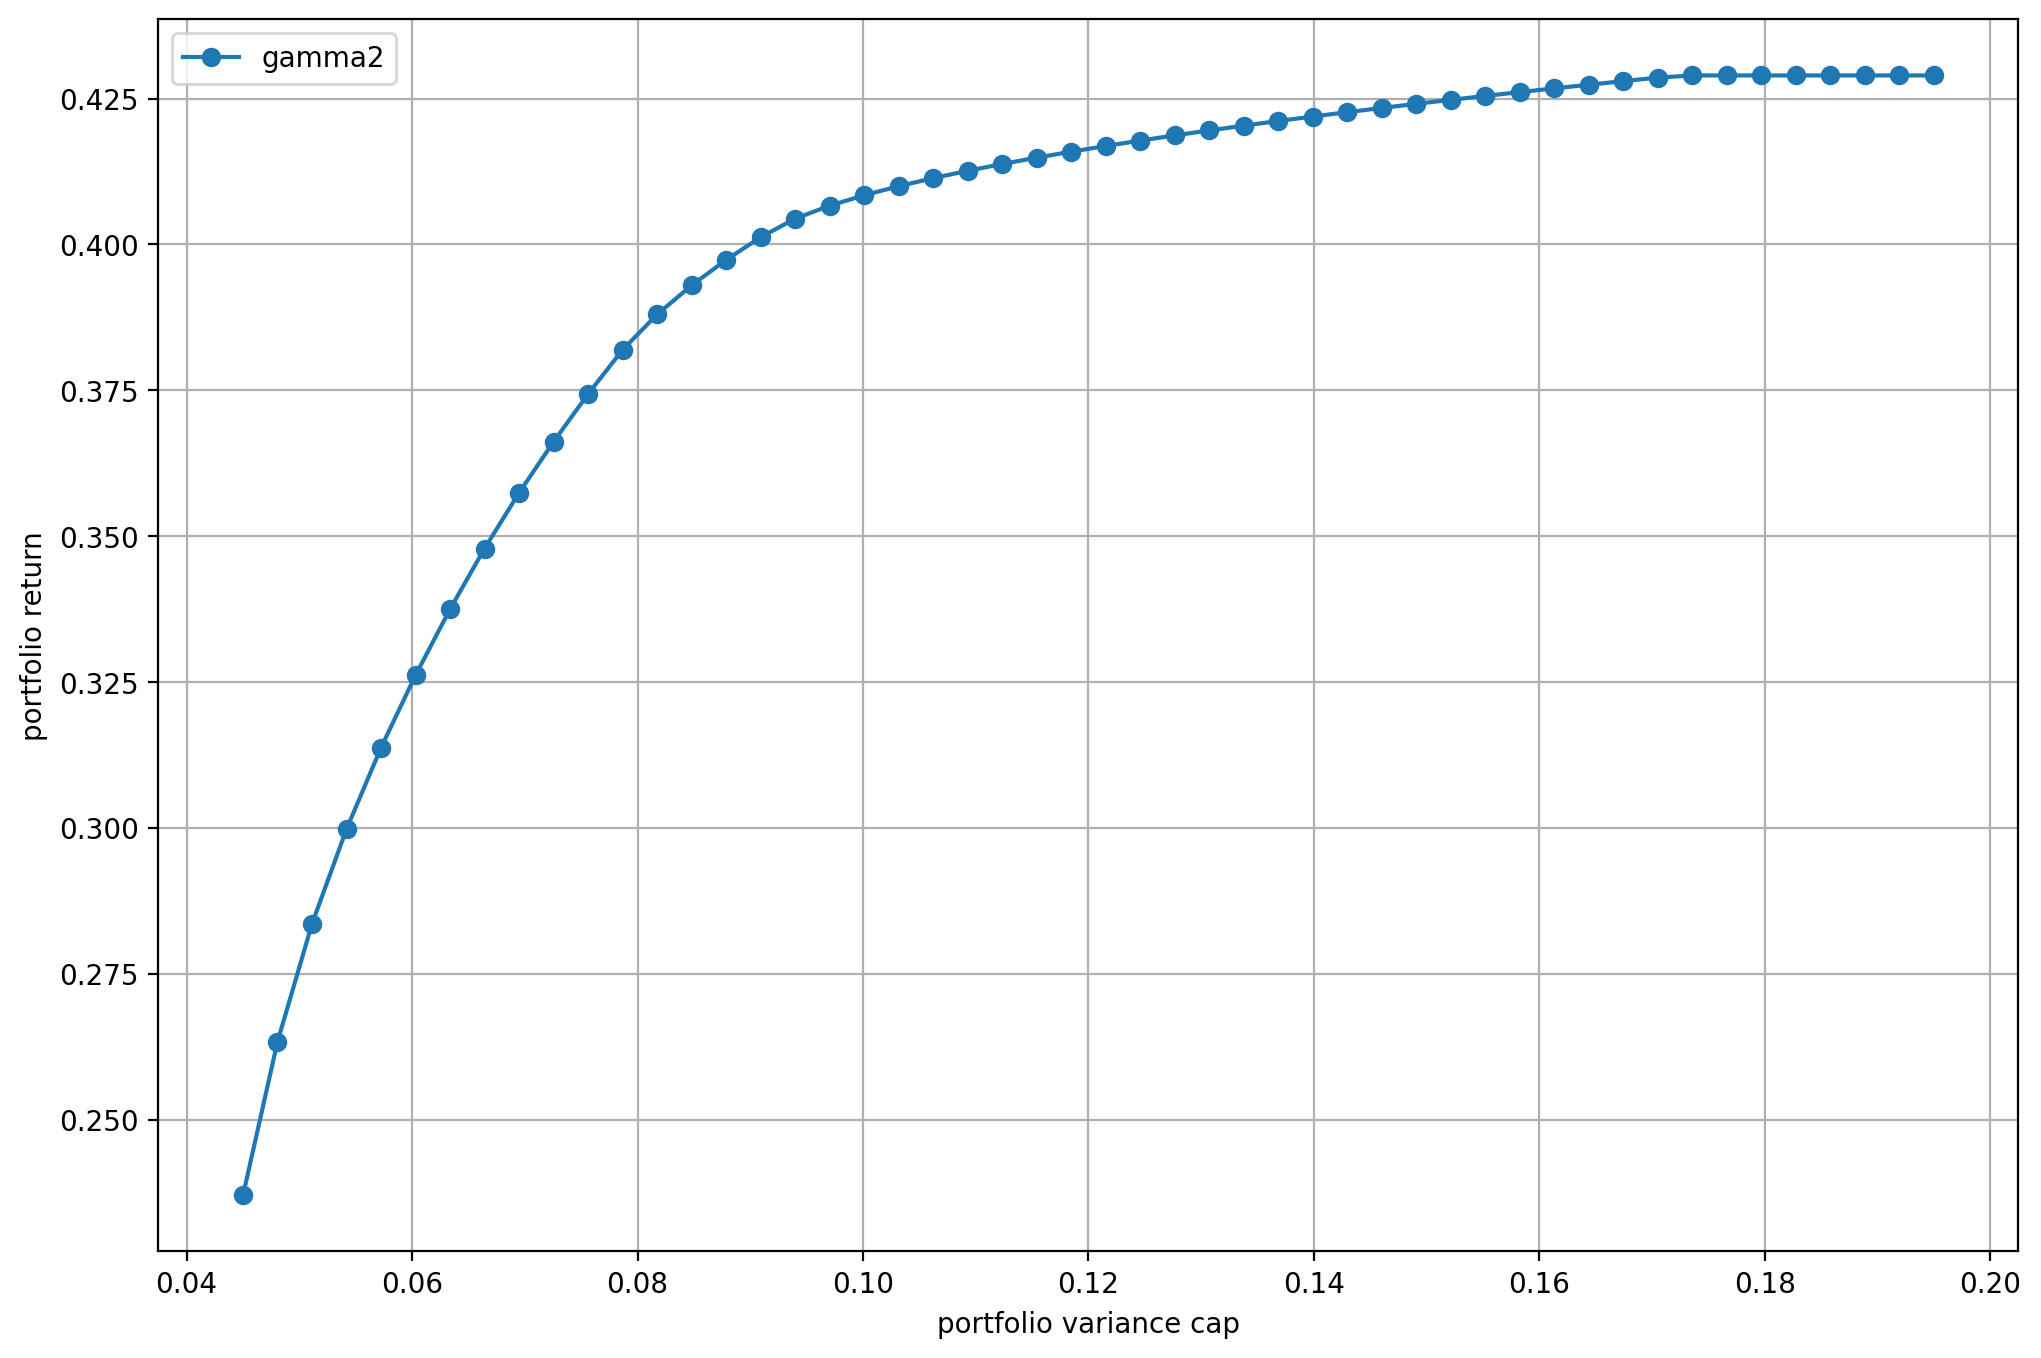

In [25]:
ax = df_result.plot(x="gamma2", y="return", style="-o",
                    xlabel="portfolio variance cap", ylabel="portfolio return", grid=True)
ax.legend(["gamma2"]);

In [28]:
df_result.iloc[::-1]

,gamma2,obj,return,g. exp.,time,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
49,0.195000,0.428958,0.428958,1.0,0.0,-5.729693e-14,-4.295694e-14,-3.617818e-13,-3.152444e-13,1.000000e+00,3.145823e-12,-1.290822e-13,-3.801795e-13
48,0.191939,0.428958,0.428958,1.0,0.0,-1.516001e-13,-1.121249e-13,-9.421589e-13,-8.205206e-13,1.000000e+00,8.259079e-12,-3.332591e-13,-9.886597e-13
47,0.188878,0.428958,0.428958,1.0,0.0,-4.453720e-13,-3.155232e-13,-2.702192e-12,-2.358496e-12,1.000000e+00,2.315776e-11,-8.513478e-13,-2.831072e-12
46,0.185816,0.428958,0.428958,1.0,0.0,-3.204530e-12,-1.884799e-12,-1.756947e-11,-1.541411e-11,1.000000e+00,1.610033e-10,2.282033e-12,-1.821040e-11
45,0.182755,0.428958,0.428958,1.0,0.0,-3.404057e-11,-1.699923e-11,-1.682098e-10,-1.476903e-10,1.000000e+00,1.671679e-09,9.835423e-11,-1.719574e-10
44,0.179694,0.428958,0.428958,1.0,0.0,-2.447475e-10,-1.113690e-10,-1.145088e-09,-1.005121e-09,1.000000e+00,1.176141e-08,9.464127e-10,-1.160009e-09
43,0.176633,0.428958,0.428958,1.0,0.0,-1.488569e-09,-6.084178e-10,-6.766484e-09,-5.960463e-09,9.999999e-01,6.777363e-08,6.687434e-09,-6.808235e-09
42,0.173571,0.428958,0.428958,1.0,0.0,-1.463120e-12,-9.188250e-13,-7.434128e-12,-6.270708e-12,1.000000e+00,-1.418262e-11,1.492761e-12,-7.442846e-12
41,0.170510,0.428585,0.428585,1.0,0.0,-2.032426e-09,4.404558e-09,-1.089699e-08,-1.554715e-08,9.896616e-01,1.033832e-02,6.875085e-08,-1.318047e-08
40,0.167449,0.427983,0.427983,1.0,0.0,-2.328545e-10,6.804819e-10,-9.472925e-10,-1.677409e-09,9.729501e-01,2.704989e-02,1.278108e-08,-1.088900e-09


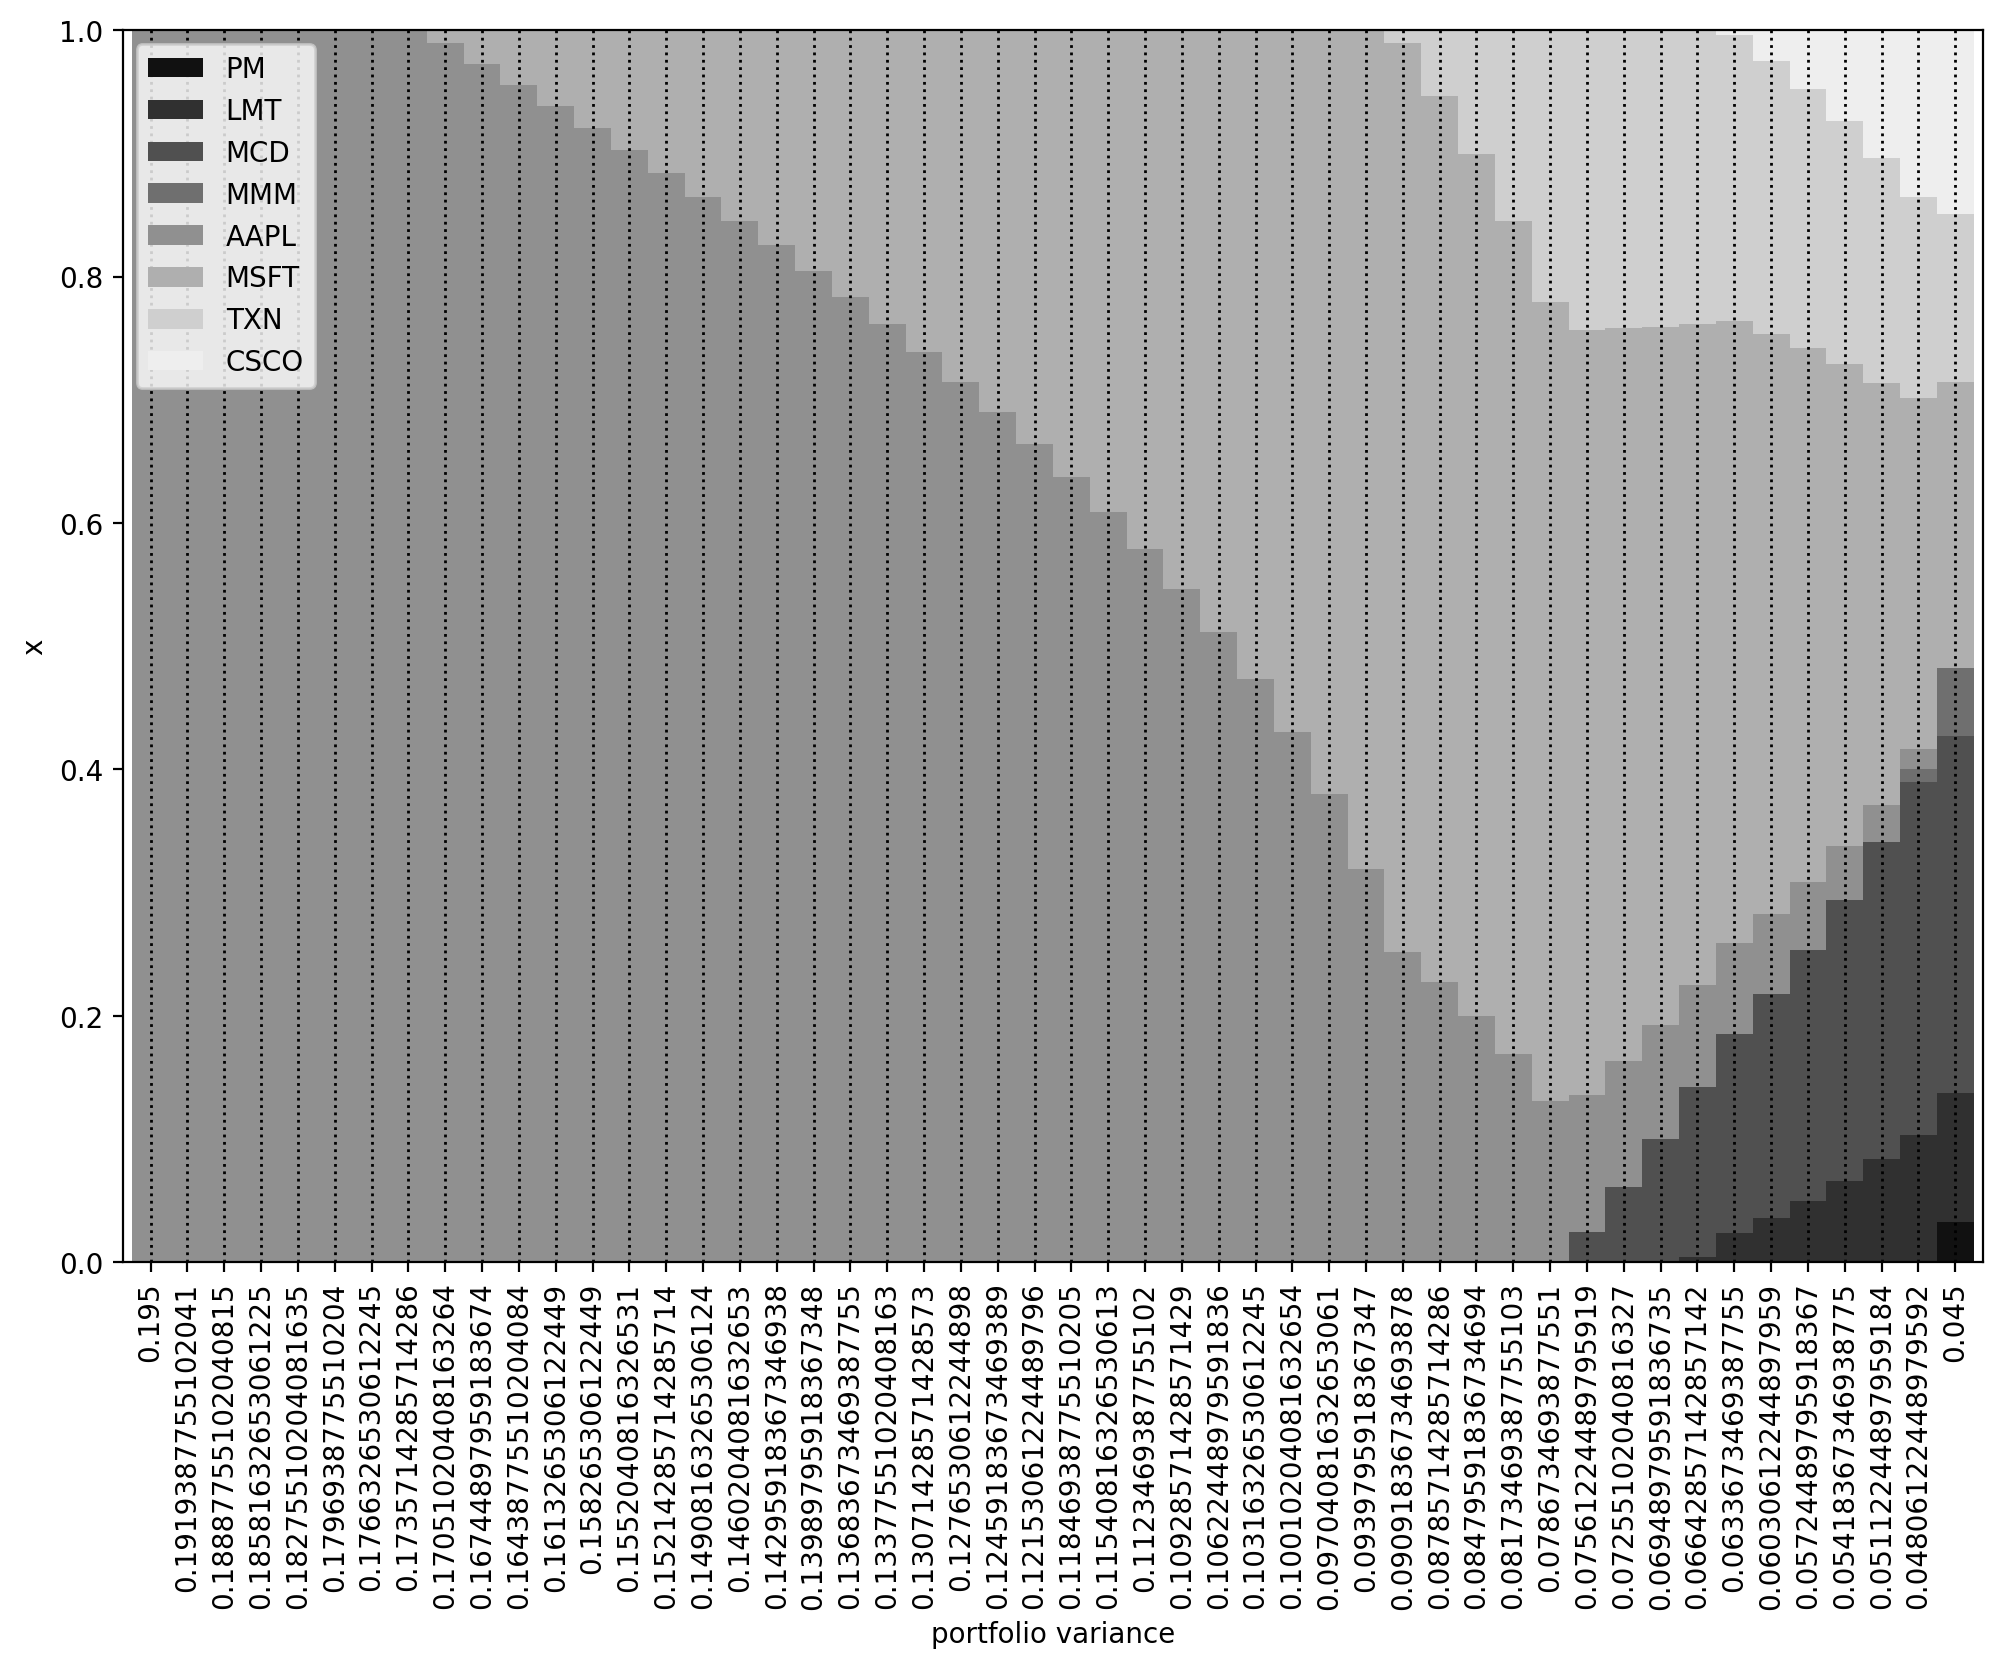

In [30]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax = plt.gca()
ax.set_xticks(df_result.iloc[::-1]['gamma2'])
df_result.iloc[::-1].set_index('gamma2').iloc[:, 4:].plot.bar(ax=ax, colormap=my_cmap, xlabel='portfolio variance', ylabel="x", stacked=True, width=1.0)
ax.set_ylim([0, 1])
ax.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)

# Test result

In [91]:
expected_x = np.array([0., 0.09126, 0.26911, 0., 0.02531, 0.32162, 0.17652, 0.11618])
diff = np.sum(np.abs(expected_x - x))
assert diff < 1e-4, f"Resulting portfolio does not match expected one. Difference is {diff}"